In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCClassifierInv
from pclib.optim.train import train
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity
from pclib.utils.customdataset import PreloadedDataset

In [2]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

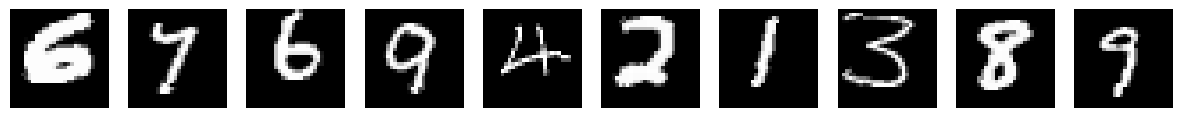

Max value:  tensor(2.8215, device='cuda:0')
Min value:  tensor(-0.4242, device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [7]:
torch.manual_seed(seed)

model_name = 'FCClassifierInv'
model = FCClassifierInv(
    in_features=INPUT_SHAPE, 
    num_classes=NUM_CLASSES, 
    hidden_sizes=[200, 128, 32],
    bias=True, 
    symmetric=True, 
    actv_fn=identity,
    steps=60,
    gamma=0.1,
).to(device)

In [8]:
# Train Loop
BATCH_SIZE = 1000

log_dir = f'examples/mnist/out/logs/{model_name}'

NUM_EPOCHS = 3
train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS,
    lr=0.0001,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    optim='AdamW',
    log_dir=log_dir,
    scheduler='ReduceLROnPlateau',
)

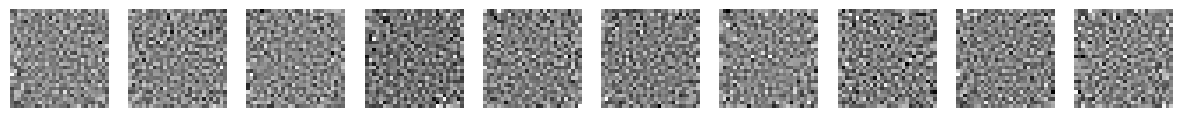

In [9]:
targets = torch.arange(NUM_CLASSES).to(device)
y = format_y(targets, NUM_CLASSES)
_, state = model(y=y)
images = state[-1]['x']

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.detach().squeeze().cpu().view(28,28), cmap='gray')
    ax.axis('off')

In [10]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

Current Val Acc: 0.099 | error_rate: 90.10 %


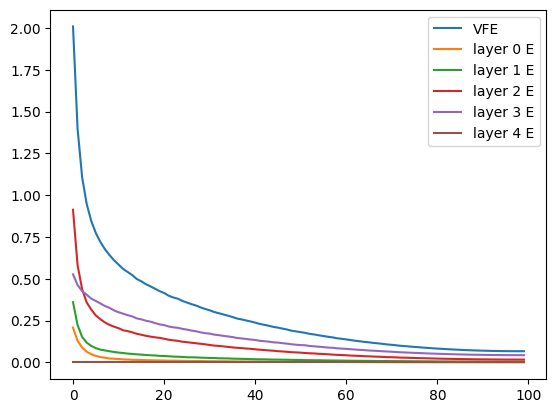

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


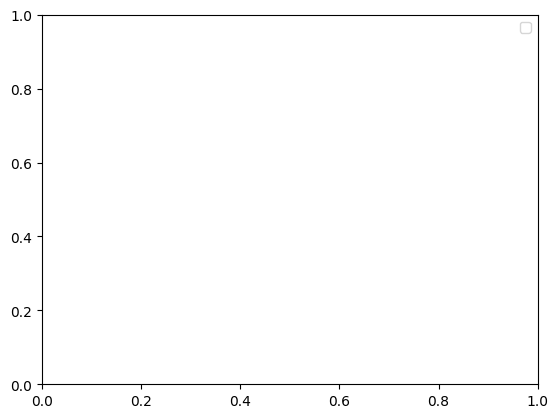

In [11]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images.view(images.shape[0], -1)
y = format_y(y, 10)
vfes, X, E = track_vfe(model, y=y, steps=100, plot_Es=True)